In [1]:
# imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import Basemap

import gzip
import pickle
import copy

import spacepy.irbempy as irbem

import spacepy.time as spt
import spacepy.coordinates as spc

import ctypes as ct
import datetime
import xflib

In [2]:
# # Let's do it totally realistically:
# q = -1.602e-19
# m = 9.1e-31
# B0 = 30e-6

R2D = 180.0/np.pi
D2R = np.pi/180.0
# R_E = 6371.
# import numpy as np
# from numpy import arctan2, sqrt
# # import numexpr as ne

def spherical_to_cartesian(r_in):
    x = r_in[0]*np.cos(D2R*r_in[1])*np.cos(D2R*r_in[2])
    y = r_in[0]*np.cos(D2R*r_in[1])*np.sin(D2R*r_in[2])
    z = r_in[0]*np.sin(D2R*r_in[1])
    #print x, y, z
    return np.array([x, y, z]).T

def cartesian_to_spherical(x_in):
    ''' cartesian to spherical (degrees)'''
    rads = np.linalg.norm(x_in,axis=0)
    lons = R2D*np.arctan2(x_in[1], x_in[0]);
    lats = R2D*np.arcsin(x_in[2]/rads)
    return np.array([rads, lats, lons]).T

def bfield(x_in):
    Bo = (3.12e-5)
    D2R = np.pi/180.
    R_E = 6371e3;

    R = x_in[0]
    theta = (90. - x_in[1])*D2R
    phi   = x_in[2]*D2R
    
    Bor3  = Bo*pow(R, -3.0)
    
    Brad = -2.0*Bor3*np.cos(theta);
    Btheta = -1.0*Bor3*np.sin(theta);
    Bphi = 0.0;    # Dipole model has no variation in longitude (here for completeness)

    B_out = np.zeros(3)
    B_out[0] = Brad;        # Up
    B_out[1] = Btheta;      # South
    B_out[2] = Bphi;        # East

    return B_out
def transform_data_sph2car(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M, d_in)

    return d_out

def transform_data_car2sph(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M.T, d_in)

    return d_out

In [3]:
# Load coastlines (for plotting)
with gzip.open('python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

['lat', 'lon']


In [38]:
## Try it with streamplot, because nothing else fuckin' works

# The grid to run the vector field on
gxx = np.linspace(-10, 10, 600)
gyy = np.linspace(-5,5, 400)
bmodel = 0


print np.shape(gxx), np.shape(gyy)
gx, gz = np.meshgrid(gxx, gyy)
gx = gx.ravel()
gz = gz.ravel()
gc = np.array([gx, gz])


L = 6
Ls = np.arange(2,10)
lam_s = np.arccos(np.sqrt(1./np.array(Ls)))*R2D

Ls = np.concatenate([-Ls, Ls])
# startpoints = np.array([np.cos(lam_s*D2R), np.sin(lam_s*D2R)]).T
startpoints = np.array([Ls, np.zeros_like(Ls)]).T
print np.shape(startpoints)


do_field = True
if do_field:
    # Get some field values:
    field = []
    Bv_IGRF = None
    Bmag_IGRF = None
    Bv_Tsyg = None
    Bmag_Tsyg = None
    
    # IRBEM library can only do 100k points at a time
    chunk_size = 100000
    start_ind = 0
    stop_ind = min(len(gx.ravel()),chunk_size)

    print "total length", len(gx.ravel())
    while (start_ind < len(gx.ravel())):
        print "doing", start_ind, stop_ind
        cv = np.vstack([gx[start_ind:stop_ind],np.zeros(stop_ind-start_ind),gz[start_ind:stop_ind]]).T
        pos = spc.Coords(cv,'GEO','car')
        t = datetime.datetime(2010,6,1,12,0,0)
        tv = spt.Ticktock([t for x in range(stop_ind-start_ind)])
        B_IGRF = irbem.get_Bfield(tv, pos, extMag='0',options=[1,0,5,5,0], omnivals=None)        
        B_Tsyg = irbem.get_Bfield(tv, pos, extMag='T05',options=[1,0,5,5,0], omnivals=None)
        if Bv_IGRF is None:
            Bv_IGRF = B_IGRF['Bvec']
            Bmag_IGRF = B_IGRF['Blocal']
            Bv_Tsyg = B_Tsyg['Bvec']
            Bmag_Tsyg = B_Tsyg['Blocal']
        else:
            Bv_IGRF = np.concatenate([Bv_IGRF, B_IGRF['Bvec']])
            Bmag_IGRF = np.concatenate([Bmag_IGRF, B_IGRF['Blocal']])
            Bv_Tsyg = np.concatenate([Bv_Tsyg, B_Tsyg['Bvec']])
            Bmag_Tsyg = np.concatenate([Bmag_Tsyg, B_Tsyg['Blocal']])

        start_ind = stop_ind
        stop_ind = min(len(gx.ravel()), start_ind + chunk_size)

    # B = irbem.get_Bfield(tv, pos, extMag='0',options=[1,0,0,0,bmodel], omnivals=None)
    # Bv = B['Bvec']
    print np.shape(Bv)

(600,) (400,)
(16, 2)
total length 240000
doing 0 100000
doing 100000 200000
doing 200000 240000
(240000, 3)


/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in less


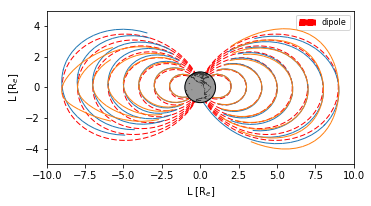

In [42]:
import matplotlib.patches as mpatches


# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5#4 
fig_height = 3
fig_size =  [fig_width+1,fig_height+1]
params = {'font.family': 'Sans Serif',
          'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


fig, ax = plt.subplots(1,1)

earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 200./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k-', zorder=101, linewidth=0.5, alpha=0.6)

# ax.pcolorfast(gxx,gyy,np.log10(Bmag.reshape([len(gyy), len(gxx)])), vmin = 0, vmax = 6, cmap= plt.cm.jet, zorder=90, alpha=0.5)





u = Bv_IGRF[:,0].reshape([len(gyy),len(gxx)])
v = Bv_IGRF[:,2].reshape([len(gyy),len(gxx)])
# print np.shape(u)
pigrf = ax.streamplot(gxx, gyy, u, v, linewidth=1, start_points = startpoints, arrowstyle='-', minlength=0.2, zorder=98)

u = Bv_Tsyg[:,0].reshape([len(gyy),len(gxx)])
v = Bv_Tsyg[:,2].reshape([len(gyy),len(gxx)])
# print np.shape(u)
ptsyg = ax.streamplot(gxx, gyy, u, v, linewidth=1, start_points = startpoints, arrowstyle='-', minlength=0.2, zorder=98)




for L in Ls:
    # Plot the fieldlines
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    pdip = ax.plot(Lx,Ly,color='r',linewidth=1, linestyle='dashed', zorder=96)  # Field line

dip = mpatches.Patch(color='r', linewidth=1, linestyle='dashed', label='dipole')


ax.set_xlim([-10, 10])
ax.set_ylim([-5, 5])
ax.set_aspect('equal')

ax.set_xlabel('L [R$_e$]')
ax.set_ylabel('L [R$_e$]')

# ax.legend([pdip, pigrf, ptsyg],['dipole','IGRF','Tsyg'])

ax.legend(handles=[dip])

fig.savefig('fieldline_models.pdf')



## HEY!! A thought -- this really can be used to show how valid it would be to remap fieldline footprints between
## igrf and dipole -- in the plasmapshere, it looks to be pretty dipolar; igrf just changes the footprint.

20.6257420353 47080849.2163


ValueError: Axes don't match array shape. Got (200, 400), expected (399, 199).

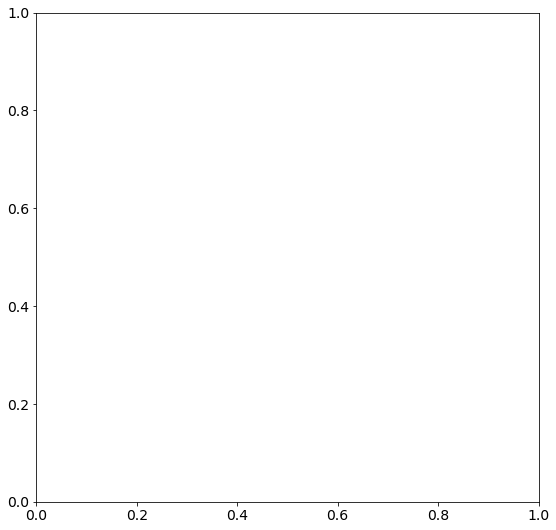

In [239]:
fig, ax = plt.subplots(1,1)

Bmag = np.linalg.norm(Bv, axis=1)
print np.min(Bmag), np.max(Bmag)
ax.pcolorfast(gxx,gyy,np.log10(Bmag.reshape([len(gxx), len(gyy)])), vmin = 0, vmax = 6, cmap= plt.cm.jet)
ax.set_aspect('equal')